In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from roc_plot import plot_ROC
from math import exp
%matplotlib inline

In [2]:
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

In [3]:
def fix_nan_train(data): # WASTED
    # 使用对应分类的列均值来填充nan
    real_some = data.loc[data.values[:,-1] == 1]
    fake_some = data.loc[data.values[:,-1] == 0]
    real_some_mod = real_some.fillna(real_some.mean(axis=0))
    fake_some_mod = fake_some.fillna(fake_some.mean(axis=0))
    data_mod = pd.concat([real_some_mod, fake_some_mod], axis=0).sort_index()
    return data_mod

def fix_nan_test(data): # WASTED
    return data.fillna(data.mean(axis=0))
    
def fix_nan_all(data):
    return data.fillna(1) # 太神秘了，随便找了个值fillna，竟然效果很好，想不明白

def flatten(data):  # 平滑化，把取值限制在[0,1]以防exp上溢
    return (data - data.mean(axis=1).reshape((-1,1))) / data.var(axis=1).reshape((-1,1))
    # data = data + data.min(axis=1).reshape((-1,1))
    # return data / data.max(axis=1).reshape((-1,1))
    
def load_file(file, method):
    data = pd.read_csv(file, header=None)
    values = fix_nan_all(data).values
#     if(method == 'train'):
#         values = fix_nan_train(data).values
#     else:
#         values = fix_nan_test(data).values
    flattened = flatten(values[:, :-1].T)
    return np.row_stack((flattened,np.ones(flattened.shape[1]))), values[:, -1].reshape((1,-1))

In [4]:
train_data, train_label = load_file("salted_fish/salted_fish_train.csv", 'train')
test_data, test_label = load_file("salted_fish/salted_fish_test.csv", 'test')

In [5]:
def initialize_zeros(dim):
    theta = np.zeros((dim, 1))
    return theta

In [6]:
def bp(theta, X, Y, C):
    m = X.shape[1]  # 获得样本总数
    A = sigmoid(np.dot(theta.T, X))
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    dtheta = (1 / m) * (1 / C) * np.dot(X, (A - Y).T)

    cost = np.squeeze(cost)

    grads = {"dtheta": dtheta}

    return grads, cost

In [7]:
def optimize(theta, X, Y, iter_times, alpha, C, show_epoch = False):
    costs = []
    mini = 1
    for i in range(1, iter_times + 1):
        if iter_times % mini == 0:
            grads, cost = bp(theta, X, Y, C)
        dtheta = grads['dtheta']
        theta = theta - alpha * (1 / mini) * dtheta
        if i % 1000 == 0:
            costs.append(cost)
        if show_epoch and i % 1000 == 0:
            print("Cost after %6i epochs : %f" % (i, cost))  
            
    params = {"theta": theta}
    
    grads = {"dth": dtheta}
    
    return params, grads, costs

In [8]:
def predict(theta, X):
    m = X.shape[1]
    test_prediction = np.zeros((1, m))
    theta = theta.reshape(X.shape[0],1)
    test_score = sigmoid(np.dot(theta.T, X))
    for i in range(test_score.shape[1]):
        test_prediction[0, i] = 1 if test_score[0, i] > 0.5 else 0
        pass
    return test_prediction, test_score

In [9]:
def model(train_data, train_label, test_data, test_label, iter_times=10000, alpha=0.09, C=1.0, show_epoch = False):
    theta = initialize_zeros(train_data.shape[0])
    params, grads, costs = optimize(theta, train_data, train_label, iter_times, alpha, C, show_epoch)
    
    theta = params["theta"]
    
    train_prediction, train_score = predict(theta, train_data)
    test_predction, test_score = predict(theta, test_data)
    
    train_acc = 100 - np.mean(np.abs(train_prediction - train_label)) * 100
    test_acc = 100 - np.mean(np.abs(test_predction - test_label)) * 100

    print("train accuracy\t: %f" % train_acc)
    print("test accuracy\t: %f"%test_acc)

    d = {"costs": costs,
         "test_prediction": test_predction, 
         "train_prediction" : train_prediction, 
         "test_score" : test_score,
         "train_score" : train_score,
         "train_acc" : train_acc,
         "test_acc" : test_acc,
         "theta" : theta, 
         "learning_rate" : alpha,
         "num_iterations": iter_times}
    
    return d

In [10]:
d = model(train_data,  #训练集数据
          train_label, #训练集标签
          test_data,   #测试集数据
          test_label,  #测试集标签
          iter_times=7000,  #迭代次数
          alpha=0.009, #学习率
          C=0.01,  # 正则化系数
          show_epoch=True) # 是否显示迭代损失函数记录

Cost after   1000 epochs : 0.541315
Cost after   2000 epochs : 0.524871
Cost after   3000 epochs : 0.513994
Cost after   4000 epochs : 0.506254
Cost after   5000 epochs : 0.500595
Cost after   6000 epochs : 0.496390
Cost after   7000 epochs : 0.493224
train accuracy	: 75.400000
test accuracy	: 80.223881


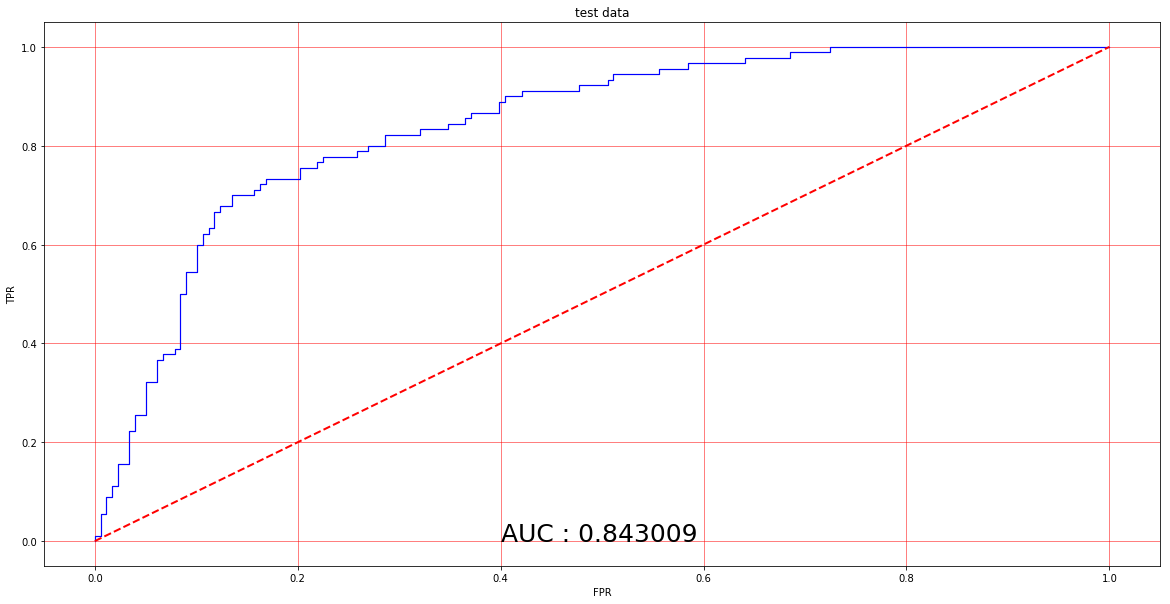

In [11]:
plot_ROC(d['test_score'].reshape((-1, 1)), test_label.reshape(-1, 1), 'test data')

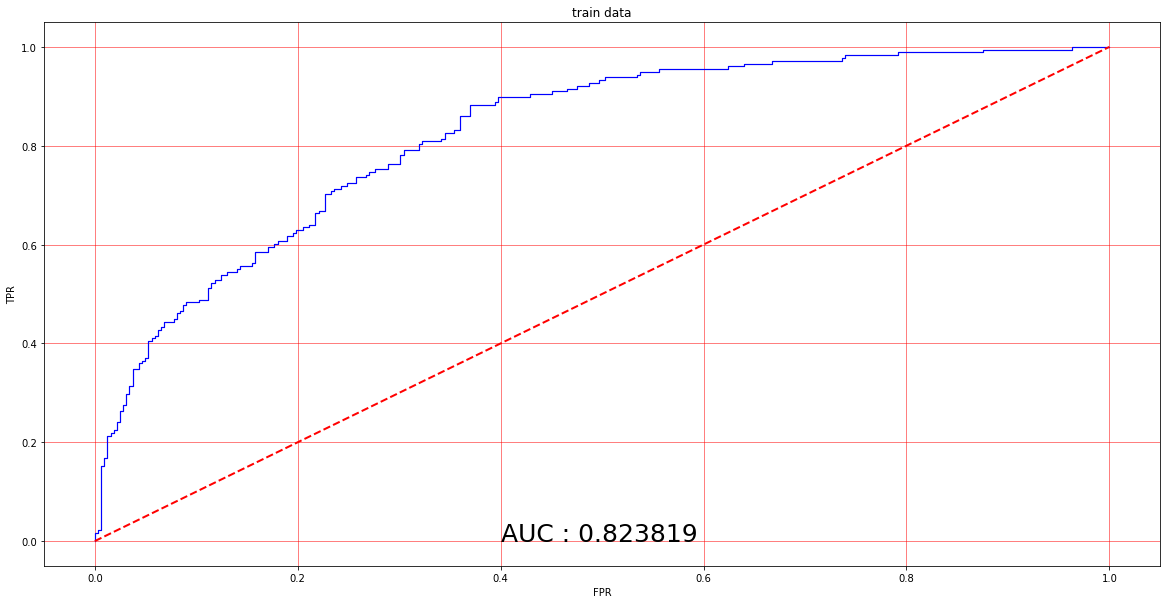

In [12]:
plot_ROC(d['train_score'].reshape((-1, 1)), train_label.reshape(-1, 1), "train data")